# Wassertein Generative Adversial Network with Gradient Penalty

In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils,metrics,optimizers

In [58]:
train_data = utils.image_dataset_from_directory(
    "../data/CelebA/img_align_celeba",labels=None,
    color_mode="rgb",
    image_size=(64,64),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

Found 202599 files belonging to 1 classes.


In [59]:
def preprocess(img):
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [60]:
from tensorflow.keras import layers,models

In [61]:
critic_input = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 256)         5245

In [62]:
Z_DIM = 128

In [63]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    3, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose_15 (Conv2  (None, 4, 4, 512)         1048576   
 DTranspose)                                                     
                                                                 
 batch_normalization_12 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_16 (Conv2  (None, 8, 8, 256)         2097

In [64]:
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [65]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [66]:
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [67]:


# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.legacy.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.legacy.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [68]:
fit = wgangp.fit(train,epochs=25,steps_per_epoch=2)

Epoch 1/25
2/2 [==============================] - 13s 6s/step - c_loss: 4.6781 - c_wass_loss: -2.3326 - c_gp: 0.7011 - g_loss: 0.1974
Epoch 2/25
2/2 [==============================] - 10s 5s/step - c_loss: -31.1833 - c_wass_loss: -35.9611 - c_gp: 0.4778 - g_loss: 0.3504
Epoch 3/25
2/2 [==============================] - 10s 5s/step - c_loss: -71.6992 - c_wass_loss: -96.1099 - c_gp: 2.4411 - g_loss: -14.4128
Epoch 4/25
2/2 [==============================] - 10s 5s/step - c_loss: -91.3913 - c_wass_loss: -126.9217 - c_gp: 3.5530 - g_loss: 0.6713
Epoch 5/25
2/2 [==============================] - 11s 5s/step - c_loss: -109.6771 - c_wass_loss: -164.1182 - c_gp: 5.4441 - g_loss: 25.1908
Epoch 6/25
2/2 [==============================] - 11s 5s/step - c_loss: -104.9582 - c_wass_loss: -160.7466 - c_gp: 5.5788 - g_loss: 20.2442
Epoch 7/25
2/2 [==============================] - 11s 5s/step - c_loss: -103.9541 - c_wass_loss: -163.0423 - c_gp: 5.9088 - g_loss: 6.8549
Epoch 8/25
2/2 [=================

In [69]:
wgangp.save("wgangp.keras")

In [70]:
number_of_images = 5
noise_vectors = tf.random.normal(shape=(number_of_images,Z_DIM))
print(noise_vectors.shape)

imgs = wgangp.generator.predict(noise_vectors)
print(imgs.shape)

(5, 128)
1/1 [==============================] - 0s 93ms/step
(5, 64, 64, 3)


In [72]:
imgs = (imgs + 1.0) / 2.0

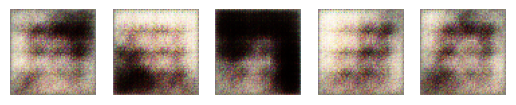

In [73]:
fig,axs = plt.subplots(1,5)

for i in range(5):
    axs[i].imshow(imgs[i],cmap=None)
    axs[i].axis("off")
plt.show()

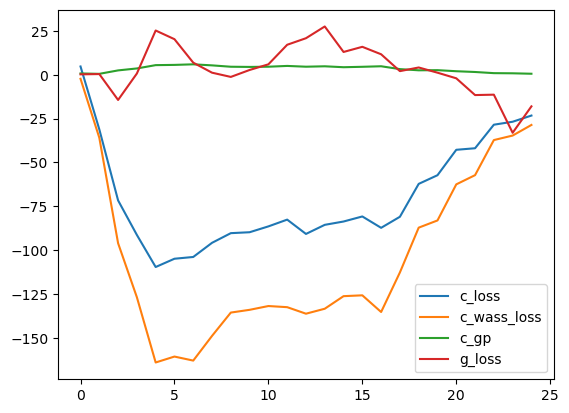

In [76]:
for key in fit.history:
    plt.plot(fit.history[key],label=key)
plt.legend()
plt.show()